# Import


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Data

In [4]:
df = pd.read_csv('data/Walmart.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


## Columns
- Store - id-store
- Date - дата с переодичностью в неделю
- Weekly_Sales - продажи за неделю - *целевая переменная*
- Holiday_Flag - Были ли праздники на неделе
- Temperatire - температура 
- Fuel_Price - Цена бензина в регионе
- CPI - Индекс 
- Unemployment - уровень безработицы

In [5]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [6]:
df.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df['day'] = df['Date'].dt.day
df['month'] = df['Date'].dt.month

In [8]:
df['day_sin'] = np.sin(df['day'] / 30 )
df['day_cos'] = np.cos(df['day'] / 30)
df['month_sin'] = np.sin(df['month'] / 12)
df['month_cos'] = np.cos(df['month'] / 12)

In [9]:
Corr_cols = ['Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'day_cos', 'day_sin', 'month_cos', 'month_sin']

<Axes: >

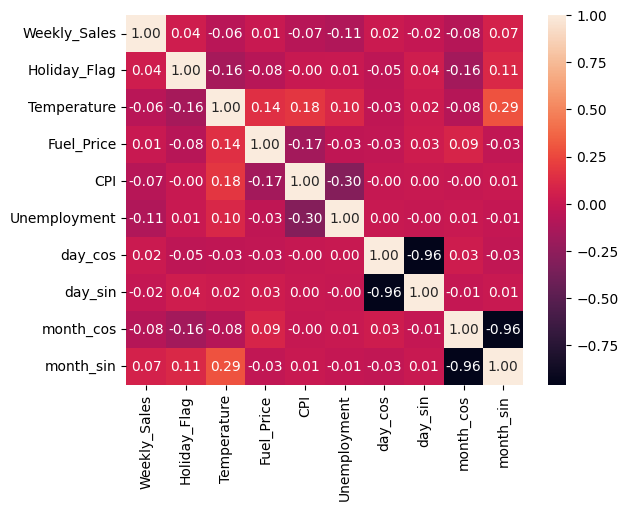

In [10]:
sns.heatmap(df[Corr_cols].corr(), annot=True, fmt='.2f')

Целевая переменная не имеет значимой корреляции ни с одним из признаков 

In [28]:
FEATURES = [
    'Store',
    'Holiday_Flag',
    'Temperature',
    'Fuel_Price',
    'CPI',
    'Unemployment',
    'day_cos',
    'day_sin',
    'month_cos',
    'month_sin'
]
target = 'Weekly_Sales'

In [29]:
train, test = train_test_split(df, train_size=0.7, stratify=df['Store'])

X_train = train[FEATURES]
y_train = train[target]

X_test = test[FEATURES]
y_test = test[target]

In [30]:
lm = LinearRegression()
lm.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [31]:
coef = pd.DataFrame({'name': np.append(lm.feature_names_in_, 'Intercept') , 'wi': np.append(lm.coef_, lm.intercept_)})
coef

,name,wi
0,Store,-1.537231e+04
1,Holiday_Flag,6.305959e+04
2,Temperature,-1.285635e+03
3,Fuel_Price,2.350629e+04
4,CPI,-2.283857e+03
5,Unemployment,-2.141318e+04
6,day_cos,1.937677e+05
7,day_sin,6.691821e+04
8,month_cos,-5.610730e+05
9,month_sin,-9.788564e+04


In [32]:
def get_metrics(X, y, model):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    rmse = mse ** (1/2)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return pd.DataFrame({
         'MSE':[mse],
         'RMSE': [rmse],
         'MAE': [mae],
         'R2':[r2]   
    })

In [33]:
pd.concat([
          get_metrics(X_train, y_train, lm),
          get_metrics(X_test, y_test, lm)])

,MSE,RMSE,MAE,R2
0,2.732843e+11,522766.033308,430540.162121,0.152728
0,2.660257e+11,515776.836039,429056.574412,0.138838



# Decision Tree

In [34]:
dt =DecisionTreeRegressor(max_depth=8)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [35]:
pd.concat([
          get_metrics(X_train, y_train, dt),
          get_metrics(X_test, y_test, dt)])

,MSE,RMSE,MAE,R2
0,2.556217e+10,159881.730588,90159.317697,0.920749
0,3.658733e+10,191278.153961,105250.345688,0.881562


In [36]:
rf = RandomForestRegressor(n_estimators=100, criterion='squared_error', max_depth=6)
rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [37]:
pd.concat([
          get_metrics(X_train, y_train, rf),
          get_metrics(X_test, y_test, rf)])

,MSE,RMSE,MAE,R2
0,5.729758e+10,239369.120158,146439.021454,0.822358
0,5.766924e+10,240144.212294,150321.287219,0.813317


In [40]:
cat_reg =CatBoostRegressor(n_estimators=1000, max_depth=6, learning_rate=1e-3, verbose=100)
cat_reg.fit(X_train, y_train)

0:	learn: 567674.1007634	total: 1.79ms	remaining: 1.79s
100:	learn: 543116.1580568	total: 156ms	remaining: 1.39s
200:	learn: 521455.6584587	total: 308ms	remaining: 1.23s
300:	learn: 501729.4550476	total: 458ms	remaining: 1.06s
400:	learn: 484512.8524118	total: 608ms	remaining: 908ms
500:	learn: 468726.7957334	total: 758ms	remaining: 755ms
600:	learn: 454314.4403827	total: 911ms	remaining: 605ms
700:	learn: 441474.6390556	total: 1.06s	remaining: 453ms
800:	learn: 429509.9365023	total: 1.22s	remaining: 303ms
900:	learn: 418347.1518976	total: 1.37s	remaining: 151ms
999:	learn: 408699.8370508	total: 1.53s	remaining: 0us


In [41]:
pd.concat([
          get_metrics(X_train, y_train, cat_reg),
          get_metrics(X_test, y_test, cat_reg)])

,MSE,RMSE,MAE,R2
0,1.670356e+11,408699.836238,341585.057704,0.482134
0,1.576735e+11,397081.221121,337399.962664,0.489589


In [23]:
pd.DataFrame({'names': cat_reg.feature_names_, 'importance':cat_reg.feature_importances_}).sort_values('importance', ascending=False)

,names,importance
4,Unemployment,50.918918
3,CPI,32.005408
7,month_cos,4.625246
8,month_sin,4.570924
2,Fuel_Price,4.059743
1,Temperature,1.670554
5,day_cos,0.801642
6,day_sin,0.779385
0,Holiday_Flag,0.568180
